# Deep Belief Network, MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Set Configs

In [3]:
BATCH_SIZE = 64

## Load Datasets

In [4]:
mnist_datasets = torchvision.datasets.MNIST('./datasets/MNIST/', train=True, download=False,
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize((0.1307,), (0.3081,))]))

In [5]:
mnist_datasets.train_data = mnist_datasets.train_data.type(torch.FloatTensor)/255

## Visualize Datasets

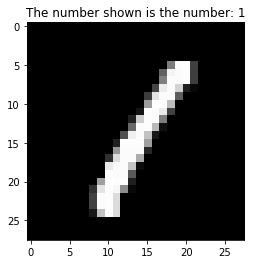

In [7]:
idx = np.random.randint(10)
image = mnist_datasets.train_data[idx]
plt.imshow(image, cmap='gray')
plt.title("The number shown is the number: {}".format(mnist_datasets.train_labels[idx]))
plt.show()

## Import The [Network](https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf)

In [8]:
from DBN import DBNNet

#### Initialize DBN Network

In [9]:
dbn = DBNNet(visible_units=28*28,
             hidden_units=[28*28, 18*18],
             k=5,
             learning_rate=0.01,
             learning_rate_decay=True,
             xavier_init=True,
             increase_to_cd_k=False,
             use_gpu=False)

## Pre-Train DBN Network

In [10]:
n_epochs = 1
batch_size = 10

dbn.train_static(mnist_datasets.train_data, mnist_datasets.train_labels, n_epochs, batch_size)

Training the RBM layer index: 1
RBM Net is fitting: 6000it [01:19, 75.55it/s]
Epoch: 1, Average Cost: 0.21977363526821136, STD Cost: 0.10714917629957199, Average Gradient: 14337.6025390625, STD Gradient: 2910.1806640625
Training the RBM layer index: 2
RBM Net is fitting: 6000it [00:44, 135.01it/s]
Epoch: 1, Average Cost: 0.26484325528144836, STD Cost: 0.11712158471345901, Average Gradient: 5989.884765625, STD Gradient: 1485.1859130859375


#### Visualizing trained layer

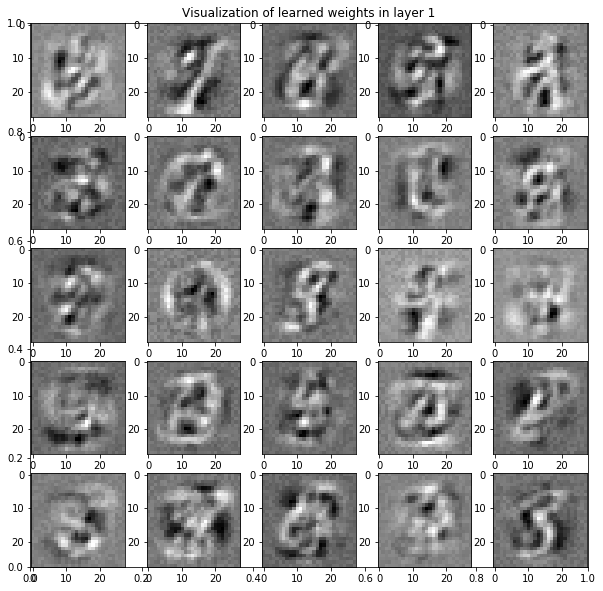

In [11]:
idx_layer = 1
learned_weights = dbn.rbm_layers[idx_layer-1].W.transpose(0,1).numpy()
fig = plt.figure(3, figsize=(10,10))
plt.title('Visualization of learned weights in layer {}'.format(idx_layer))
for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

plt.savefig('./images/dbn_trained_layer_{}.png'.format(idx_layer))
plt.show()

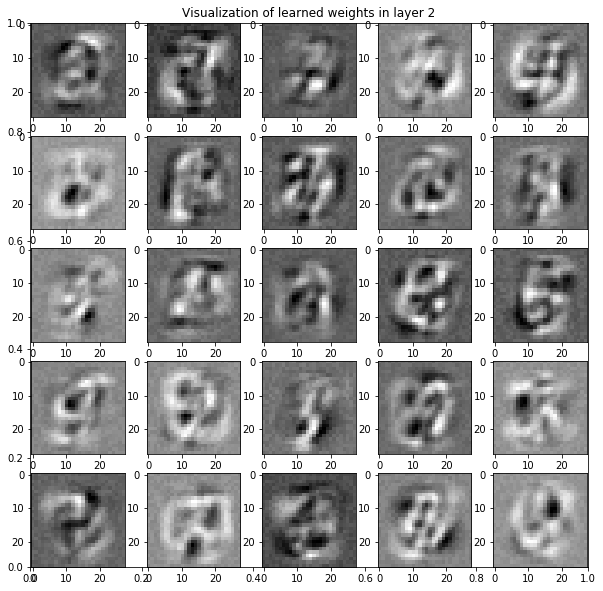

In [12]:
idx_layer = 2
learned_weights = dbn.rbm_layers[idx_layer-1].W.transpose(0,1).numpy()
fig = plt.figure(3, figsize=(10,10))
plt.title('Visualization of learned weights in layer {}'.format(idx_layer))
for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

plt.savefig('./images/dbn_trained_layer_{}.png'.format(idx_layer))
plt.show()

## Train DBN Network

In [13]:
digits = 5
particular_mnist = []

limit = mnist_datasets.train_data.shape[0]
for i in range(limit):
    if(mnist_datasets.train_labels[i] == digits):
        particular_mnist.append(mnist_datasets.train_data[i].numpy())

In [14]:
print('Number of digits: {}'.format(len(particular_mnist)))

Number of digits: 5421


In [15]:
train_data = torch.stack([torch.Tensor(i) for i in particular_mnist])
train_label = torch.stack([torch.Tensor(digits) for i in range(len(particular_mnist))])

In [16]:
n_epochs = 20
dbn.train_static(train_data, train_label, n_epochs, batch_size)

Training the RBM layer index: 1
RBM Net is fitting: 542it [00:07, 70.68it/s]
Epoch: 1, Average Cost: 0.1482580006122589, STD Cost: 0.018104512244462967, Average Gradient: 11917.677734375, STD Gradient: 642.9249267578125
RBM Net is fitting: 542it [00:07, 73.75it/s]
Epoch: 2, Average Cost: 0.13699892163276672, STD Cost: 0.01677621155977249, Average Gradient: 11738.7705078125, STD Gradient: 621.756591796875
RBM Net is fitting: 542it [00:07, 69.36it/s]
Epoch: 3, Average Cost: 0.13261111080646515, STD Cost: 0.015779845416545868, Average Gradient: 11686.7822265625, STD Gradient: 620.0386352539062
RBM Net is fitting: 542it [00:11, 45.54it/s]
Epoch: 4, Average Cost: 0.1303480863571167, STD Cost: 0.01602851040661335, Average Gradient: 11679.9267578125, STD Gradient: 629.3671264648438
RBM Net is fitting: 542it [00:09, 54.88it/s]
Epoch: 5, Average Cost: 0.1289028376340866, STD Cost: 0.015429152175784111, Average Gradient: 11694.7861328125, STD Gradient: 623.7103271484375
RBM Net is fitting: 542it

The original digits: 1


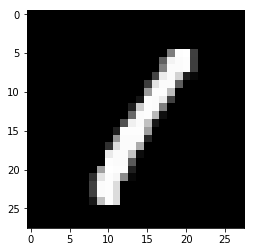

The reconstructed image


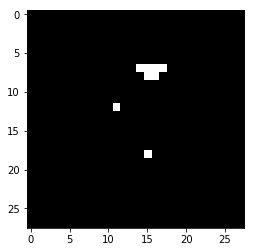

In [19]:
idx = 3
image = mnist_datasets.train_data[3]
reconstructed_image = image.view(1, -1).type(torch.FloatTensor)

_, reconstructed_image = dbn.reconstruct(reconstructed_image)
reconstructed_image = reconstructed_image.view((28,28))

print('The original digits: {}'.format(mnist_datasets.train_labels[idx]))
plt.imshow(image, cmap='gray')
plt.savefig('./images/dbn_original_image.png')
plt.show()

print('The reconstructed image')
plt.imshow(reconstructed_image, cmap='gray')
plt.savefig('./images/dbn_reconstructed_image.png')
plt.show()

---